In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import datetime
import argparse

from azureml.core.run import Run
from azureml.core import Workspace, Dataset
from tf_agents.environments import tf_py_environment, py_environment, utils
from tf_agents.networks import sequential
from tf_agents.agents.dqn import dqn_agent
from tf_agents.policies import EpsilonGreedyPolicy, random_tf_policy
from tf_agents.policies.q_policy import QPolicy
from tf_agents.policies.boltzmann_policy import BoltzmannPolicy
from tf_agents.trajectories import trajectory, Trajectory, PolicyStep, time_step as ts
from tf_agents.replay_buffers import TFUniformReplayBuffer
from tf_agents.metrics import tf_metrics
from tf_agents.specs import array_spec
from tf_agents.drivers import dynamic_step_driver
from tf_agents.utils import common
from keras.layers import Input, Dense, Activation, BatchNormalization, Dropout
from helper_functions import *
from environment_functions import *

In [3]:
def train_agent(n_iterations):
    time_step = None
    policy_state = agent.collect_policy.get_initial_state(train_env.batch_size)
    iterator = iter(dataset)
    
    for iteration in range(n_iterations):
        current_metrics = []
        
        time_step, policy_state = collect_driver.run(time_step, policy_state)
        trajectories, buffer_info = next(iterator)
        
        train_loss = agent.train(trajectories)
        all_train_loss.append(train_loss.loss.numpy())

        for i in range(len(train_metrics)):
            current_metrics.append(train_metrics[i].result().numpy())
            
        all_metrics.append(current_metrics)
        
        if iteration % 1000 == 0:
            print("\nIteration: {}, loss:{:.2f}".format(iteration, train_loss.loss.numpy()))
            print('Train step counter: {}, epsilon: {:.3f}'.format(int(train_step_counter), epsilon_fn(train_step_counter)))
            
            for i in range(len(train_metrics)):
                print('{}: {}'.format(train_metrics[i].name, train_metrics[i].result().numpy()))
                
                if type(i) == tf_metrics.AverageReturnMetric:
                    run.log('Training avg reward', train_metrics[i].result().numpy())

In [4]:
# Env settings
num_actions = (150-30) / 3
num_features = 33  # TODO: Make dynamic

# Set seed for reproducability
seed = 123
tf.random.set_seed(seed)

In [5]:
dpc_game = DynamicPricingCompetition()
simulator = CreateAirlineSimulation()
environment = AirlineEnvironment(dpc_game, simulator, num_features, num_actions, 1.0, 30, 3, 120, 0.5)
utils.validate_py_environment(environment, episodes=5)
train_env = tf_py_environment.TFPyEnvironment(environment)
eval_env = tf_py_environment.TFPyEnvironment(environment)

In [6]:
init = tf.keras.initializers.HeUniform()
layer1 = Dense(units=20, input_shape=(num_features,), activation='relu', 
               kernel_initializer=init, name='hidden_layer1')
layer2 = Dense(units=40, activation='relu', kernel_initializer=init, name='hidden_layer2')
layer3 = Dense(units=num_actions, activation=None, kernel_initializer=init)
q_net = sequential.Sequential([layer1, layer2, layer3])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

In [60]:
train_step_counter = tf.Variable(0)

epsilon_fn = tf.keras.optimizers.schedules.PolynomialDecay(
                initial_learning_rate=100., 
                decay_steps=150000,
                end_learning_rate=1.)

agent = dqn_agent.DqnAgent(
    time_step_spec=train_env.time_step_spec(),
    action_spec=train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    target_update_period=2000,
    td_errors_loss_fn=tf.keras.losses.Huber(reduction="none"),
    gamma=1.0,
    train_step_counter=train_step_counter,
    boltzmann_temperature=lambda: epsilon_fn(train_step_counter),
    epsilon_greedy=None,
#     emit_log_probability=True
)

agent.initialize()

In [17]:
time_step = train_env.reset()

In [18]:
qpolicy = QPolicy(train_env.time_step_spec(), train_env.action_spec(), q_net)
action_step = qpolicy.action(time_step)
distribution_step = qpolicy.distribution(time_step)

In [14]:
action_step

PolicyStep(action=<tf.Tensor: shape=(1,), dtype=int32, numpy=array([37])>, state=(), info=())

In [15]:
distribution_step.action.logits

<tf.Tensor: shape=(1, 40), dtype=float32, numpy=
array([[-113.62004  ,   69.014885 ,    6.4843054,  -53.991074 ,
         -71.02123  ,  -61.332737 , -150.32036  ,  -39.92784  ,
         126.12921  ,   88.6173   ,  -49.590527 ,   67.95235  ,
          25.215254 ,  -28.292763 ,   47.904274 ,   -9.141963 ,
         -80.52591  ,   72.98913  ,  -65.71312  ,  -10.517427 ,
        -180.47351  ,   20.181072 ,   46.943    , -169.46312  ,
          17.836353 , -123.4585   ,   -3.11441  ,  -47.741253 ,
         -10.559328 ,  -15.7915745,  -74.38231  ,   82.725914 ,
          86.91493  ,   16.173769 ,  -25.238    ,  122.92806  ,
         -37.751934 ,  133.9032   ,   -8.481404 ,   27.410416 ]],
      dtype=float32)>

In [19]:
action_step

PolicyStep(action=<tf.Tensor: shape=(1,), dtype=int32, numpy=array([37])>, state=(), info=())

In [24]:
np.argmax(distribution_step.action.logits[0])

37

In [25]:
distribution_step.action.logits[0]

<tf.Tensor: shape=(40,), dtype=float32, numpy=
array([-113.62004  ,   69.014885 ,    6.4843054,  -53.991074 ,
        -71.02123  ,  -61.332737 , -150.32036  ,  -39.92784  ,
        126.12921  ,   88.6173   ,  -49.590527 ,   67.95235  ,
         25.215254 ,  -28.292763 ,   47.904274 ,   -9.141963 ,
        -80.52591  ,   72.98913  ,  -65.71312  ,  -10.517427 ,
       -180.47351  ,   20.181072 ,   46.943    , -169.46312  ,
         17.836353 , -123.4585   ,   -3.11441  ,  -47.741253 ,
        -10.559328 ,  -15.7915745,  -74.38231  ,   82.725914 ,
         86.91493  ,   16.173769 ,  -25.238    ,  122.92806  ,
        -37.751934 ,  133.9032   ,   -8.481404 ,   27.410416 ],
      dtype=float32)>

array([-113.62004  ,   69.014885 ,    6.4843054,  -53.991074 ,
        -71.02123  ,  -61.332737 , -150.32036  ,  -39.92784  ,
        126.12921  ,   88.6173   ,  -49.590527 ,   67.95235  ,
         25.215254 ,  -28.292763 ,   47.904274 ,   -9.141963 ,
        -80.52591  ,   72.98913  ,  -65.71312  ,  -10.517427 ,
       -180.47351  ,   20.181072 ,   46.943    , -169.46312  ,
         17.836353 , -123.4585   ,   -3.11441  ,  -47.741253 ,
        -10.559328 ,  -15.7915745,  -74.38231  ,   82.725914 ,
         86.91493  ,   16.173769 ,  -25.238    ,  122.92806  ,
        -37.751934 ,  133.9032   ,   -8.481404 ,   27.410416 ],
      dtype=float32)

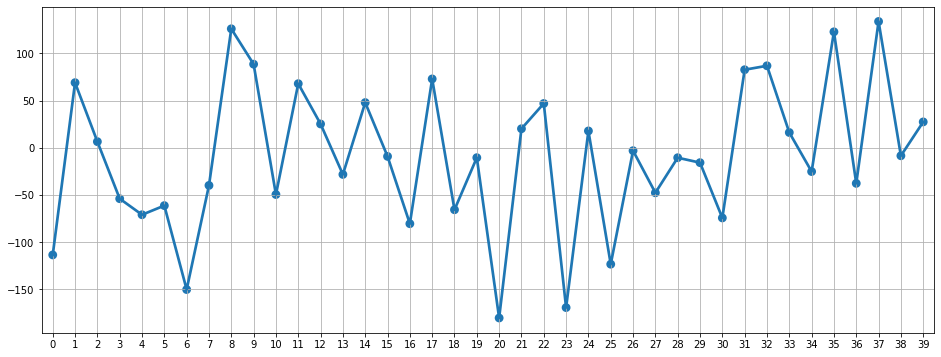

In [42]:
plt.figure(figsize=(16,6))
sns.pointplot(x=[x for x in range(len(distribution_step.action.logits[0]))], y=np.array(distribution_step.action.logits[0]))
plt.grid()

In [33]:
np.max(distribution_step.action.logits[0])

133.9032

In [26]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

In [31]:
np.set_printoptions(suppress=True)

In [32]:
softmax(distribution_step.action.logits[0])

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.00042035, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.00001711, 0.        , 0.99956256, 0.        , 0.        ],
      dtype=float32)

In [48]:
softmax(distribution_step.action.logits[0] / 100)

array([0.00666179, 0.04137751, 0.02214101, 0.01209362, 0.01019988,
       0.01123755, 0.00461534, 0.01391977, 0.07325017, 0.05033806,
       0.01263769, 0.04094018, 0.02670207, 0.01563733, 0.03350288,
       0.01893797, 0.00927506, 0.04305506, 0.01075593, 0.01867927,
       0.00341389, 0.02539111, 0.03318236, 0.00381125, 0.02480269,
       0.00603758, 0.02011457, 0.01287357, 0.01867144, 0.01771962,
       0.00986275, 0.04745812, 0.04948838, 0.02439373, 0.01612238,
       0.07094245, 0.01422597, 0.07917182, 0.01906348, 0.0272947 ],
      dtype=float32)

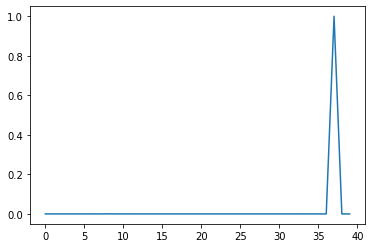

In [28]:
plt.plot(softmax(distribution_step.action.logits[0]))

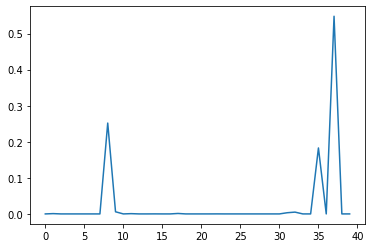

In [49]:
plt.plot(softmax(distribution_step.action.logits[0] / 10))

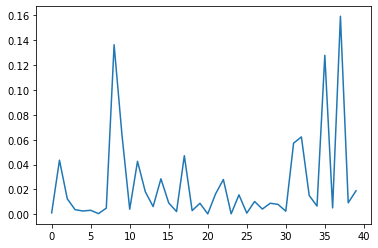

In [50]:
plt.plot(softmax(distribution_step.action.logits[0] / 50))

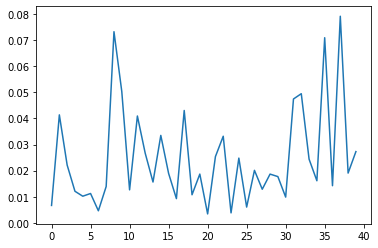

In [75]:
plt.plot(softmax(distribution_step.action.logits[0] / 100))

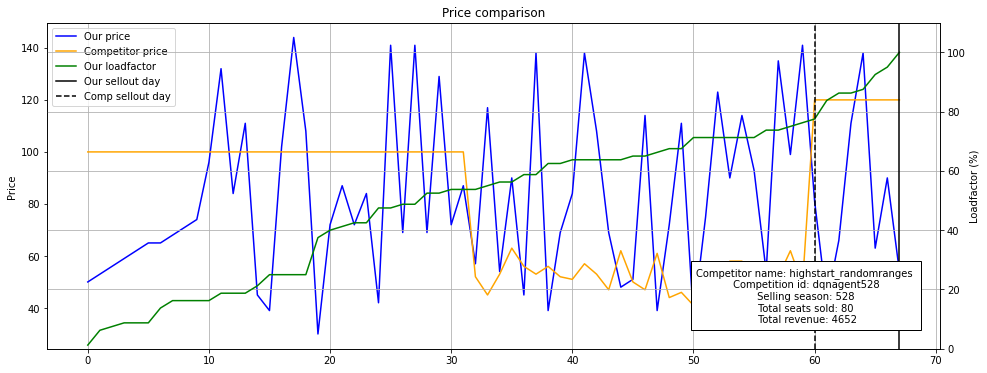

In [74]:
selling_season = dpc_game.competition_results_df['selling_season'].max() - 4
competition_id = f'dqnagent{str(selling_season)}'

plot_price_and_loadfactor(dpc_game.competition_results_df, competition_id, selling_season, None)